# Training a Image Classifier for Fashion MNIST Dataset

Shaw And Partners Coding Challenge

Matheus de Andrade Silva

## Dependencies

In [205]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Import Data

In [206]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms

In [207]:
# Download FashionMNIST dataset

# Transform the data from range [0, 255] to range [0.0, 1.0]
transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMNIST(root='data/', train=True, download=True, transform=transform)
test_set =  FashionMNIST(root='data/', train=False, download=True, transform=transform)

In [208]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = (train_set.data, train_set.targets), (test_set.data, test_set.targets)

In [209]:
print('>> Train test size analysis:')
print('Train images shape:', X_train_raw.shape)
print('Train labels shape:', y_train_raw.shape)
print('Test images shape:', X_test_raw.shape)
print('Test labels shape:', y_test_raw.shape)

>> Train test size analysis:
Train images shape: torch.Size([60000, 28, 28])
Train labels shape: torch.Size([60000])
Test images shape: torch.Size([10000, 28, 28])
Test labels shape: torch.Size([10000])


## Data Analysis

In [210]:
print('>> Train label distribution analysis:')
for value in np.array(np.unique(y_train_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Train label distribution analysis:
Label: 0, Count: 6000
Label: 1, Count: 6000
Label: 2, Count: 6000
Label: 3, Count: 6000
Label: 4, Count: 6000
Label: 5, Count: 6000
Label: 6, Count: 6000
Label: 7, Count: 6000
Label: 8, Count: 6000
Label: 9, Count: 6000


In [211]:

print('>> Test label distribution analysis:')
for value in np.array(np.unique(y_test_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Test label distribution analysis:
Label: 0, Count: 1000
Label: 1, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 5, Count: 1000
Label: 6, Count: 1000
Label: 7, Count: 1000
Label: 8, Count: 1000
Label: 9, Count: 1000


>> Image examples:


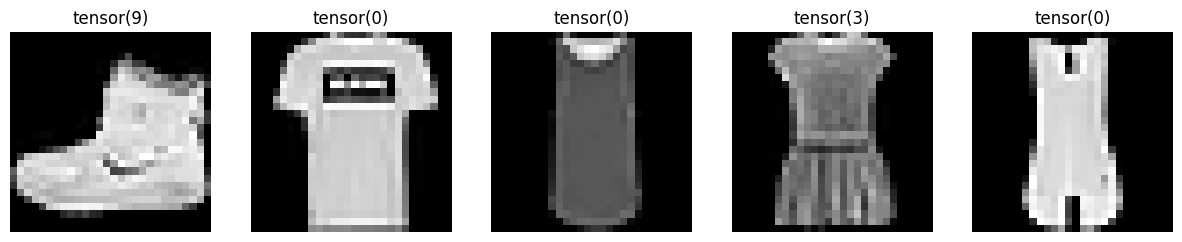

In [212]:
print('>> Image examples:')
fig, axes = plt.subplots(1, 5, figsize=(15,15))
for i in range(5):
    axes[i].imshow(X_train_raw[i], cmap='gray')
    axes[i].set_title(y_train_raw[i])
    axes[i].axis('off')

In [213]:
print('>> Image array data analysis:')
print(f'Image array shape: {X_train_raw[0].shape}')
print(f'Total pixels: {X_train_raw[0].shape[0] * X_train_raw[0].shape[1]}')
print(f'Min value: {X_train_raw[0].min()}')
print(f'Max value: {X_train_raw[0].max()}')

>> Image array data analysis:
Image array shape: torch.Size([28, 28])
Total pixels: 784
Min value: 0
Max value: 255


## Data Handling

In [214]:
from torch.utils.data import random_split, Subset

In [215]:
# Change the pixel values range from 0-255 to 0-1
train_set.data = train_set.data.type(torch.float32) / 255
test_set.data = test_set.data.type(torch.float32) / 255
print(f'Max value: {train_set.data[0].max()}')

Max value: 1.0


In [216]:
# Create a validation set
train_set, val_set = random_split(train_set, [50000, 10000])

## Training

In [217]:
from torch import nn
from torch import optim

In [218]:
# Some useful constants
IMAGE_SIZE = 28*28
IMAGE_LENGTH = 28
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f'Using {DEVICE} device')

Using cpu device


In [246]:
def train(model, train_set, valid_set, opt, loss_fn, epochs=20, batch_size=64):
    """
    Train a model and evaluate it at every epoch.
    
    Args:
        model: a pytorch model
        train_set: dataset to train on
        valid_set: dataset to evaluate on
        opt: a pytorch optimizer
        loss_fn: a pytorch loss function
        epochs: number of epochs to train
    """
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(214))
    val_loader = DataLoader(valid_set, batch_size=len(valid_set),shuffle=True, generator=torch.manual_seed(214))

    for epoch in range(epochs):
        for batch in train_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # Forward pass
            outputs = model(X)
            loss = loss_fn(outputs, y)

            # Backward and optimize
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Evaluate
        with torch.no_grad():
            X_val, y_val = next(iter(val_loader))
            X_val = X_val.to(DEVICE)
            y_val = y_val.to(DEVICE)
            
            val_loss = loss_fn(model(X_val), y_val)
            print(f'>>> Epoch: {epoch+1}, loss: {loss.item()}, val_loss: {val_loss.item()}')
    

### Simple Multilayer Perceptron Network 

In [240]:
class FashionMNISTModel_MLP_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

In [247]:
clf = FashionMNISTModel_MLP_3().to(DEVICE)
opt = optim.Adam(clf.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train(clf, train_set, val_set, opt, loss_fn, epochs=10, batch_size=512)

>>> Epoch: 1, loss: 2.1812996864318848, val_loss: 2.1824376583099365
>>> Epoch: 2, loss: 2.21128511428833, val_loss: 2.1831417083740234
>>> Epoch: 3, loss: 2.166510581970215, val_loss: 2.1929678916931152
>>> Epoch: 4, loss: 2.175436019897461, val_loss: 2.1915555000305176
>>> Epoch: 5, loss: 2.205198049545288, val_loss: 2.19355845451355
>>> Epoch: 6, loss: 2.220078945159912, val_loss: 2.1950862407684326
>>> Epoch: 7, loss: 2.1924943923950195, val_loss: 2.1947860717773438
>>> Epoch: 8, loss: 2.205198287963867, val_loss: 2.207468271255493
>>> Epoch: 9, loss: 2.199336290359497, val_loss: 2.2061972618103027
>>> Epoch: 10, loss: 2.205198287963867, val_loss: 2.193323850631714


### CNN

In [ ]:
class FashionMNISTModel_MLP_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

## Save Model

In [253]:
BASE_PATH = pathlib.Path().resolve().parent / 'models'
BASE_PATH

WindowsPath('C:/Users/mathe/OneDrive/Documentos/reporitories/ShawAndPartners_MNIST/models')

In [255]:
MODEL_FOLDER_PATH = pathlib.Path().resolve().parent / 'models'
MODEL_NAME = 'model.pt'

# Create the folder if it doesn't exist
if not MODEL_FOLDER_PATH.exists():
    MODEL_FOLDER_PATH.mkdir()

# Save the model
torch.save(clf.state_dict(), pathlib.Path(MODEL_FOLDER_PATH, MODEL_NAME))